In [4]:
import pandas as pd
df = pd.read_csv("Online Retail.csv", encoding='ISO-8859-1')
print(df.head())

  ï»¿InvoiceNo StockCode                          Description  Quantity  \
0       536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1       536365     71053                  WHITE METAL LANTERN         6   
2       536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3       536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4       536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  


In [5]:
df = df[df['CustomerID'].notnull()] #removing null values from customerid 


In [6]:
df.rename(columns={df.columns[0]: 'InvoiceNo'}, inplace=True)
df = df.loc[~df['InvoiceNo'].str.startswith('C', na=False)] #removing cancelled orders
df= df[(df['Quantity']>0) & (df['UnitPrice']>0)] #removing zero and negative values
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

             InvoiceDate  UnitPrice  CustomerID         Country  
0       0

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)  #  Convert InvoiceDate to datetime


In [10]:
# recency
day=df['InvoiceDate'].max()
# Group and calculate recency
recency = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (day - x.max()).days
}).reset_index()

# Rename the column properly
recency.columns = ['CustomerID', 'Recency']


In [12]:
#frequency
freq = df.groupby('CustomerID')[['InvoiceNo']].count().reset_index()
freq.columns = ['CustomerID', 'Frequency']


In [15]:
#Monetory value 
#finding total sale
df['sales']=df['UnitPrice']*df['Quantity']
money=df.groupby(['CustomerID'])[['sales']].sum().reset_index()
money.columns = ['CustomerID', 'Monetary']

In [16]:
RFM = recency.merge(freq, on='CustomerID').merge(money, on='CustomerID')

In [17]:
#NORMALISING THE RFM VALUES 
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled=scaler.fit_transform(RFM)

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
RFM['Cluster'] = kmeans.fit_predict(scaled)


In [26]:
# View customer clusters

RFM.groupby('Cluster').agg({
    'CustomerID': 'count',        # Number of customers
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).rename(columns={'CustomerID': 'Num_Customers'}).round(3)




,Num_Customers,Recency,Frequency,Monetary
Cluster,,,,
0,1684,44.252,99.383,2108.656
1,952,257.517,26.832,634.822
2,15,3.667,2512.400,113548.132
3,1687,45.853,99.166,1809.637


In [27]:
from sklearn.metrics import silhouette_score

score = silhouette_score(scaled, RFM['Cluster'])
print("Silhouette Score:", round(score, 3))


Silhouette Score: 0.4


In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []

K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled)# Elbow Method 
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

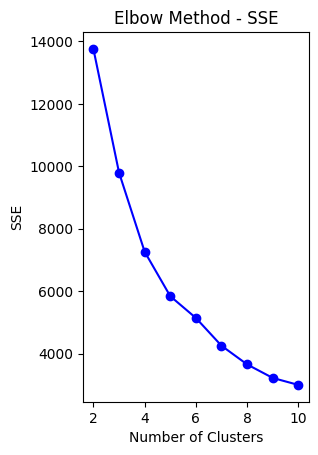

In [30]:

plt.subplot(1,2,1)
plt.plot(K, sse, 'bo-')
plt.title("Elbow Method - SSE")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

In [32]:
#improvised clustering 
kmeans = KMeans(n_clusters=6, random_state=42)
RFM['Cluster'] = kmeans.fit_predict(scaled)


In [34]:
RFM.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Num_Customers'}).round(1)


,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
0,40.5,103.9,2219.6,1618
1,243.0,29.3,521.6,540
2,0.7,4717.8,59437.6,6
3,40.0,102.4,1926.2,1624
4,6.7,826.8,190863.5,6
5,248.7,26.4,750.7,544


In [38]:
RFM.to_csv("rfm_clusters.csv", index=False)
